In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import torch.nn as nn
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
np.random.seed(1232)
os.chdir('C:\\Users\\rober\\Desktop\\RAND_pro\\Data\\dep')
data = pd.read_csv("Rand_train.csv", sep=',')
data_val = pd.read_csv("Rand_valid.csv", sep=',')

In [4]:
data.cost = (np.exp(data.cost) - 0.5)*((data.cost != 0) * 1)
data_val.cost = (np.exp(data_val.cost) - 0.5)*((data_val.cost != 0) * 1)
data = shuffle(data).reset_index(drop=True)
data = data.drop(['fmde', 'lxghindx', 'lpi'], axis=1)
data_val = data_val.drop(['fmde', 'lxghindx', 'lpi'], axis=1)

In [5]:
X = data.iloc[:,1:]
Y = data.iloc[:,0]
X_val = data_val.iloc[:,1:]
Y_val = data_val.iloc[:,0]

ranking = np.load('ranking.npy')

my_index = X.columns.values[ranking]
X2 = X[my_index]
X2_val = X_val[my_index]

In [6]:
cut = 0
y1 = (Y <= cut) * 1
y2 = (Y > cut) * (-1) * (-Y)
Y2 = np.stack((y1, y2), axis=-1)

y1_val = (Y_val <= cut) * 1
y2_val = (Y_val > cut) * (-1) * (-Y_val)
Y2_val = np.stack((y1_val, y2_val), axis=-1)

In [7]:
os.chdir('C:\\Users\\rober\\Desktop\\RAND_pro\\prog_calc')
from fit6_nn import fit

In [12]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        
        self.fc11 = nn.Linear(16, 24, bias = True)
        self.fc12 = nn.Linear(24, 1, bias = True)
        
        self.fc21 = nn.Linear(16, 24, bias=True)
        self.fc22 = nn.Linear(24, 5, bias=True)
        self.fc23 = nn.Linear(5, 1, bias=True)
        
        self.drop_layer = nn.Dropout(p=0.01)
                
    def forward(self, x):        
        x1 = torch.tanh(self.fc11(x))
        x1 = self.drop_layer(x1)
        x1 = torch.sigmoid(self.fc12(x1))        
        
        x2 = self.fc21(x)
        x2 = self.drop_layer(x2)
        x2 = F.relu(self.fc22(x2))
        x2 = torch.exp(self.fc23(x2))       
        
        #x3 = torch.stack((x1[:,0], x2[:,0]), dim=1) 
        x3 = torch.cat((x1, x2), 1)
        return x3

In [13]:
def comb_error(output, target):
    output = (output + 0.0001)*0.999
    logErr1 = -1 * torch.log(output) * target[:,0].view(1,-1).t()
    logErr2 = -1 * torch.log(1 - output) * (1 - target[:,0].view(1,-1)).t()
    mseErr = torch.pow(target - output, 2) * (1 - target[:,0].view(1,-1)).t()
    return (1/output.shape[0]) * (torch.sum(logErr1,dim=0)[0] + torch.sum(logErr2,dim=0)[0] + (1/(2*950000))*torch.sum(mseErr,dim=0)[1])

In [14]:
n_epochs = 5000
lr = 0.001
verbose = 1
n_batches = 6
batch_to_avg = 2
ep_to_check = 10
clipping = 0.20
PATH = 'C:\\Users\\rober\\Desktop\\RAND_pro\\Data\\checkpoints\\mytraining7.pt'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
net = Net1()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

PATH = 'C:\\Users\\rober\\Desktop\\RAND_pro\\Data\\checkpoints\\mytraining7.pt'
net.load_state_dict(torch.load(PATH, map_location = device))
    
a, b, c = fit(X=X2, X_val=X2_val, Y=Y2, Y_val=Y2_val, net=net, optimizer=optimizer, error=comb_error, 
                n_epochs=n_epochs, n_batches=n_batches, batch_to_avg=batch_to_avg, 
                    ep_to_check=ep_to_check, clipping=clipping, PATH=PATH, device=device, 
                                            verbose=verbose, min_val_loss = float('inf'))

Epoch 1: Training Loss: 0.8452078700065613, Validation Loss: 0.9552661776542664
Epoch 2: Training Loss: 0.8446500301361084, Validation Loss: 0.9552471041679382
Epoch 3: Training Loss: 0.8468146721522013, Validation Loss: 0.9553221464157104
Epoch 4: Training Loss: 0.8461055159568787, Validation Loss: 0.9553232789039612
Epoch 5: Training Loss: 0.8462536633014679, Validation Loss: 0.9553508758544922
Epoch 6: Training Loss: 0.845066100358963, Validation Loss: 0.9553971290588379
Epoch 7: Training Loss: 0.8456437687079111, Validation Loss: 0.9553653597831726
Epoch 8: Training Loss: 0.8452294170856476, Validation Loss: 0.9554581642150879
Epoch 9: Training Loss: 0.845583975315094, Validation Loss: 0.9555151462554932
Epoch 10: Training Loss: 0.8448735872904459, Validation Loss: 0.9555155038833618
Epoch 11: Training Loss: 0.8455618719259897, Validation Loss: 0.9554805755615234
New Checkpoint Saved into PATH
Epoch 12: Training Loss: 0.8452117741107941, Validation Loss: 0.9554684162139893
Epoch 13

Epoch 102: Training Loss: 0.8447116812070211, Validation Loss: 0.955495297908783
Epoch 103: Training Loss: 0.8447232147057852, Validation Loss: 0.9555590152740479
Epoch 104: Training Loss: 0.8458192547162374, Validation Loss: 0.955524206161499
Epoch 105: Training Loss: 0.8461291790008545, Validation Loss: 0.9555178880691528
Epoch 106: Training Loss: 0.8464363217353821, Validation Loss: 0.9553940892219543
Epoch 107: Training Loss: 0.845241924126943, Validation Loss: 0.9553403258323669
Epoch 108: Training Loss: 0.8460642794768015, Validation Loss: 0.9553242921829224
Epoch 109: Training Loss: 0.8456357022126516, Validation Loss: 0.9553131461143494
Epoch 110: Training Loss: 0.8474503457546234, Validation Loss: 0.9553225040435791
Epoch 111: Training Loss: 0.8460736870765686, Validation Loss: 0.9553380608558655
Epoch 112: Training Loss: 0.8461915949980418, Validation Loss: 0.9553605318069458
Epoch 113: Training Loss: 0.8450038731098175, Validation Loss: 0.9553802013397217
Epoch 114: Training

Epoch 202: Training Loss: 0.8459847271442413, Validation Loss: 0.9553014039993286
Epoch 203: Training Loss: 0.8468843499819437, Validation Loss: 0.9552540183067322
Epoch 204: Training Loss: 0.8452770709991455, Validation Loss: 0.9552608132362366
Epoch 205: Training Loss: 0.8460301458835602, Validation Loss: 0.9552707672119141
Epoch 206: Training Loss: 0.8459201355775198, Validation Loss: 0.9552573561668396
Epoch 207: Training Loss: 0.8438349664211273, Validation Loss: 0.9552513957023621
Epoch 208: Training Loss: 0.843964010477066, Validation Loss: 0.9552667737007141
Epoch 209: Training Loss: 0.8448106149832407, Validation Loss: 0.9552534222602844
Epoch 210: Training Loss: 0.8453728953997294, Validation Loss: 0.95524001121521
Epoch 211: Training Loss: 0.8461679220199585, Validation Loss: 0.9552534818649292
New Checkpoint Saved into PATH
Epoch 212: Training Loss: 0.8456620673338572, Validation Loss: 0.9552712440490723
Epoch 213: Training Loss: 0.8456221719582876, Validation Loss: 0.95529

Epoch 301: Training Loss: 0.845019668340683, Validation Loss: 0.9551826119422913
Epoch 302: Training Loss: 0.844812790552775, Validation Loss: 0.9551779627799988
Epoch 303: Training Loss: 0.8458113571008047, Validation Loss: 0.9551970958709717
Epoch 304: Training Loss: 0.8454859852790833, Validation Loss: 0.955172061920166
Epoch 305: Training Loss: 0.8456692397594452, Validation Loss: 0.95522540807724
Epoch 306: Training Loss: 0.8462648093700409, Validation Loss: 0.9552255272865295
Epoch 307: Training Loss: 0.8447457849979401, Validation Loss: 0.9552406668663025
Epoch 308: Training Loss: 0.8449180622895559, Validation Loss: 0.9552461504936218
Epoch 309: Training Loss: 0.8461754818757375, Validation Loss: 0.9552599787712097
Epoch 310: Training Loss: 0.8455185095469157, Validation Loss: 0.9552834033966064
Epoch 311: Training Loss: 0.8457127412160238, Validation Loss: 0.9552720785140991
Epoch 312: Training Loss: 0.844676285982132, Validation Loss: 0.9552179574966431
Epoch 313: Training Lo

Epoch 401: Training Loss: 0.8445650537808737, Validation Loss: 0.9551811814308167
Epoch 402: Training Loss: 0.8455400466918945, Validation Loss: 0.9551671743392944
Epoch 403: Training Loss: 0.846727579832077, Validation Loss: 0.9551032781600952
Epoch 404: Training Loss: 0.8461588422457377, Validation Loss: 0.9550700187683105
Epoch 405: Training Loss: 0.8450174033641815, Validation Loss: 0.9550288915634155
Epoch 406: Training Loss: 0.8446817795435587, Validation Loss: 0.9550461173057556
Epoch 407: Training Loss: 0.8458922604719797, Validation Loss: 0.9550946950912476
Epoch 408: Training Loss: 0.8459923068682352, Validation Loss: 0.9551401138305664
Epoch 409: Training Loss: 0.845628579457601, Validation Loss: 0.9552143216133118
Epoch 410: Training Loss: 0.8454442421595255, Validation Loss: 0.9552774429321289
Epoch 411: Training Loss: 0.8460844854513804, Validation Loss: 0.9552355408668518
New Checkpoint Saved into PATH
Epoch 412: Training Loss: 0.8459637959798177, Validation Loss: 0.9552

Epoch 500: Training Loss: 0.8460726737976074, Validation Loss: 0.9549176692962646
Epoch 501: Training Loss: 0.8442586461702982, Validation Loss: 0.9549711346626282
New Checkpoint Saved into PATH
Epoch 502: Training Loss: 0.8457003831863403, Validation Loss: 0.9549551010131836
Epoch 503: Training Loss: 0.8451519012451172, Validation Loss: 0.9550058841705322
Epoch 504: Training Loss: 0.8452020287513733, Validation Loss: 0.9550430774688721
Epoch 505: Training Loss: 0.8455635110537211, Validation Loss: 0.9549924731254578
Epoch 506: Training Loss: 0.8457314074039459, Validation Loss: 0.9550371170043945
Epoch 507: Training Loss: 0.8439004321893057, Validation Loss: 0.9550347328186035
Epoch 508: Training Loss: 0.845012754201889, Validation Loss: 0.9550550580024719
Epoch 509: Training Loss: 0.8436608215173086, Validation Loss: 0.9549779295921326
Epoch 510: Training Loss: 0.8453073700269064, Validation Loss: 0.9549319744110107
Epoch 511: Training Loss: 0.8456277946631113, Validation Loss: 0.955

Epoch 599: Training Loss: 0.8446398774782816, Validation Loss: 0.9548551440238953
Epoch 600: Training Loss: 0.8455170094966888, Validation Loss: 0.9549306631088257
Epoch 601: Training Loss: 0.8456919193267822, Validation Loss: 0.9550154209136963
New Checkpoint Saved into PATH
Epoch 602: Training Loss: 0.8455175360043844, Validation Loss: 0.9550475478172302
Epoch 603: Training Loss: 0.8455958863099416, Validation Loss: 0.9550511240959167
Epoch 604: Training Loss: 0.8446247378985087, Validation Loss: 0.9550544023513794
Epoch 605: Training Loss: 0.8448832035064697, Validation Loss: 0.9550985097885132
Epoch 606: Training Loss: 0.8445301651954651, Validation Loss: 0.9551964402198792
Epoch 607: Training Loss: 0.8455913364887238, Validation Loss: 0.9551766514778137
Epoch 608: Training Loss: 0.8460234602292379, Validation Loss: 0.9551095366477966
Epoch 609: Training Loss: 0.8442065715789795, Validation Loss: 0.9551104307174683
Epoch 610: Training Loss: 0.8447386225064596, Validation Loss: 0.95

Epoch 699: Training Loss: 0.8445462584495544, Validation Loss: 0.9549918174743652
Epoch 700: Training Loss: 0.8465067744255066, Validation Loss: 0.9550008773803711
Epoch 701: Training Loss: 0.8440929253896078, Validation Loss: 0.9549691081047058
Epoch 702: Training Loss: 0.8439174294471741, Validation Loss: 0.9549560546875
Epoch 703: Training Loss: 0.8453179697195689, Validation Loss: 0.954925000667572
Epoch 704: Training Loss: 0.8442886769771576, Validation Loss: 0.9548673629760742
Epoch 705: Training Loss: 0.845667709906896, Validation Loss: 0.9548683166503906
Epoch 706: Training Loss: 0.8454364438851675, Validation Loss: 0.9548248052597046
Epoch 707: Training Loss: 0.8457406957944235, Validation Loss: 0.9548463225364685
Epoch 708: Training Loss: 0.8449476460615793, Validation Loss: 0.9548137187957764
Epoch 709: Training Loss: 0.8448418180147806, Validation Loss: 0.9548717737197876
Epoch 710: Training Loss: 0.8440034687519073, Validation Loss: 0.954939603805542
Epoch 711: Training Lo

Epoch 800: Training Loss: 0.8452627460161845, Validation Loss: 0.954930305480957
Epoch 801: Training Loss: 0.84485990802447, Validation Loss: 0.9549201130867004
New Checkpoint Saved into PATH
Epoch 802: Training Loss: 0.8445352216561636, Validation Loss: 0.9549587965011597
Epoch 803: Training Loss: 0.846005916595459, Validation Loss: 0.9549877643585205
Epoch 804: Training Loss: 0.8440479338169098, Validation Loss: 0.9550066590309143
Epoch 805: Training Loss: 0.8458457986513773, Validation Loss: 0.9549748301506042
Epoch 806: Training Loss: 0.843769778807958, Validation Loss: 0.9550085663795471
Epoch 807: Training Loss: 0.8441137174765269, Validation Loss: 0.9550251364707947
Epoch 808: Training Loss: 0.8440393408139547, Validation Loss: 0.9550226926803589
Epoch 809: Training Loss: 0.8439837793509165, Validation Loss: 0.954960823059082
Epoch 810: Training Loss: 0.8444086611270905, Validation Loss: 0.9548923969268799
Epoch 811: Training Loss: 0.8445733884970347, Validation Loss: 0.95474475

Epoch 900: Training Loss: 0.8442049523194631, Validation Loss: 0.9548531770706177
Epoch 901: Training Loss: 0.8450780312220255, Validation Loss: 0.9548526406288147
Epoch 902: Training Loss: 0.8443645536899567, Validation Loss: 0.9547727108001709
Epoch 903: Training Loss: 0.8434720635414124, Validation Loss: 0.9547738432884216
Epoch 904: Training Loss: 0.8454511562983195, Validation Loss: 0.9547406435012817
Epoch 905: Training Loss: 0.844233363866806, Validation Loss: 0.9547654390335083
Epoch 906: Training Loss: 0.8445205489794413, Validation Loss: 0.9547340869903564
Epoch 907: Training Loss: 0.8446325858434042, Validation Loss: 0.9547832012176514
Epoch 908: Training Loss: 0.8450439671675364, Validation Loss: 0.954815149307251
Epoch 909: Training Loss: 0.8454896807670593, Validation Loss: 0.954902708530426
Epoch 910: Training Loss: 0.844559520483017, Validation Loss: 0.9548988938331604
Epoch 911: Training Loss: 0.8446696400642395, Validation Loss: 0.9549599289894104
Epoch 912: Training 

Epoch 1000: Training Loss: 0.845429390668869, Validation Loss: 0.9546550512313843
Epoch 1001: Training Loss: 0.8450218836466471, Validation Loss: 0.9546781182289124
Epoch 1002: Training Loss: 0.8453710476557413, Validation Loss: 0.9547039270401001
Epoch 1003: Training Loss: 0.8454265594482422, Validation Loss: 0.9547538161277771
Epoch 1004: Training Loss: 0.8448644677797953, Validation Loss: 0.9547036290168762
Epoch 1005: Training Loss: 0.8457302252451578, Validation Loss: 0.9547141194343567
Epoch 1006: Training Loss: 0.8452956676483154, Validation Loss: 0.9547100067138672
Epoch 1007: Training Loss: 0.8442450066407522, Validation Loss: 0.9547242522239685
Epoch 1008: Training Loss: 0.8443261484305064, Validation Loss: 0.9547876119613647
Epoch 1009: Training Loss: 0.8438770671685537, Validation Loss: 0.9548160433769226
Epoch 1010: Training Loss: 0.8449108501275381, Validation Loss: 0.9548826217651367
Epoch 1011: Training Loss: 0.844417949517568, Validation Loss: 0.9548863172531128
Epoch 

Epoch 1099: Training Loss: 0.8431993027528127, Validation Loss: 0.9546483159065247
Epoch 1100: Training Loss: 0.842748244603475, Validation Loss: 0.9546658396720886
Epoch 1101: Training Loss: 0.8439931472142538, Validation Loss: 0.9547297358512878
Epoch 1102: Training Loss: 0.8438142438729604, Validation Loss: 0.9547423124313354
Epoch 1103: Training Loss: 0.8447119494279226, Validation Loss: 0.9547531604766846
Epoch 1104: Training Loss: 0.8443248172601064, Validation Loss: 0.9546818137168884
Epoch 1105: Training Loss: 0.8446706632773081, Validation Loss: 0.9546273350715637
Epoch 1106: Training Loss: 0.8448492189248403, Validation Loss: 0.9546284675598145
Epoch 1107: Training Loss: 0.8434192438920339, Validation Loss: 0.9545761942863464
Epoch 1108: Training Loss: 0.8442645967006683, Validation Loss: 0.954623281955719
Epoch 1109: Training Loss: 0.8441510498523712, Validation Loss: 0.9546193480491638
Epoch 1110: Training Loss: 0.8443456391493479, Validation Loss: 0.9546073079109192
Epoch 

Epoch 1198: Training Loss: 0.8439855873584747, Validation Loss: 0.9546119570732117
Epoch 1199: Training Loss: 0.8466297487417856, Validation Loss: 0.9546051621437073
Epoch 1200: Training Loss: 0.8455638686815897, Validation Loss: 0.9546482563018799
Epoch 1201: Training Loss: 0.8452098866303762, Validation Loss: 0.9546473622322083
New Checkpoint Saved into PATH
Epoch 1202: Training Loss: 0.8441157440344492, Validation Loss: 0.9546720385551453
Epoch 1203: Training Loss: 0.8440909882386526, Validation Loss: 0.9546569585800171
Epoch 1204: Training Loss: 0.8457161684830984, Validation Loss: 0.9546555876731873
Epoch 1205: Training Loss: 0.844901462395986, Validation Loss: 0.954713761806488
Epoch 1206: Training Loss: 0.844284176826477, Validation Loss: 0.954656720161438
Epoch 1207: Training Loss: 0.8443491260210673, Validation Loss: 0.9546855688095093
Epoch 1208: Training Loss: 0.8438366750876108, Validation Loss: 0.95464026927948
Epoch 1209: Training Loss: 0.844895601272583, Validation Loss:

Epoch 1296: Training Loss: 0.8458341558774313, Validation Loss: 0.9544938206672668
Epoch 1297: Training Loss: 0.8443408608436584, Validation Loss: 0.954486072063446
Epoch 1298: Training Loss: 0.8435724675655365, Validation Loss: 0.9544877409934998
Epoch 1299: Training Loss: 0.8447787165641785, Validation Loss: 0.9545713663101196
Epoch 1300: Training Loss: 0.8443643351395925, Validation Loss: 0.9545550346374512
Epoch 1301: Training Loss: 0.8434189160664877, Validation Loss: 0.9545339941978455
New Checkpoint Saved into PATH
Epoch 1302: Training Loss: 0.8447163701057434, Validation Loss: 0.9545637369155884
Epoch 1303: Training Loss: 0.8442493180433909, Validation Loss: 0.9545446038246155
Epoch 1304: Training Loss: 0.8435859382152557, Validation Loss: 0.9545854926109314
Epoch 1305: Training Loss: 0.8445043663183848, Validation Loss: 0.954549252986908
Epoch 1306: Training Loss: 0.8439160883426666, Validation Loss: 0.9545403718948364
Epoch 1307: Training Loss: 0.8445165057977041, Validation 

Epoch 1395: Training Loss: 0.8434624175230662, Validation Loss: 0.9545050263404846
Epoch 1396: Training Loss: 0.8442691365877787, Validation Loss: 0.9546059370040894
Epoch 1397: Training Loss: 0.8452350993951162, Validation Loss: 0.9545854926109314
Epoch 1398: Training Loss: 0.8451131681601206, Validation Loss: 0.9546220898628235
Epoch 1399: Training Loss: 0.8446791072686514, Validation Loss: 0.9546392560005188
Epoch 1400: Training Loss: 0.8447667757670084, Validation Loss: 0.9545490145683289
Epoch 1401: Training Loss: 0.8430504202842712, Validation Loss: 0.9544955492019653
Epoch 1402: Training Loss: 0.8446919719378153, Validation Loss: 0.9544761776924133
Epoch 1403: Training Loss: 0.8436650435129801, Validation Loss: 0.9544294476509094
Epoch 1404: Training Loss: 0.8451723456382751, Validation Loss: 0.9544409513473511
Epoch 1405: Training Loss: 0.8443708618481954, Validation Loss: 0.9544341564178467
Epoch 1406: Training Loss: 0.8449439207712809, Validation Loss: 0.954440712928772
Epoch

Epoch 1494: Training Loss: 0.8441762626171112, Validation Loss: 0.9544388055801392
Epoch 1495: Training Loss: 0.8437682688236237, Validation Loss: 0.9544998407363892
Epoch 1496: Training Loss: 0.8444632887840271, Validation Loss: 0.9544753432273865
Epoch 1497: Training Loss: 0.845134973526001, Validation Loss: 0.9544490575790405
Epoch 1498: Training Loss: 0.8442955017089844, Validation Loss: 0.9544197916984558
Epoch 1499: Training Loss: 0.8438664972782135, Validation Loss: 0.9544023871421814
Epoch 1500: Training Loss: 0.844469428062439, Validation Loss: 0.9542797803878784
Epoch 1501: Training Loss: 0.8434978822867075, Validation Loss: 0.9542401432991028
Epoch 1502: Training Loss: 0.842785100142161, Validation Loss: 0.9542512893676758
Epoch 1503: Training Loss: 0.8445585370063782, Validation Loss: 0.9542660713195801
Epoch 1504: Training Loss: 0.8453474442164103, Validation Loss: 0.954292893409729
Epoch 1505: Training Loss: 0.8449550867080688, Validation Loss: 0.9543133974075317
Epoch 15

Epoch 1593: Training Loss: 0.8433891932169596, Validation Loss: 0.9544117450714111
Epoch 1594: Training Loss: 0.8441726764043173, Validation Loss: 0.9543828964233398
Epoch 1595: Training Loss: 0.8449330826600393, Validation Loss: 0.9543301463127136
Epoch 1596: Training Loss: 0.8441358506679535, Validation Loss: 0.9542733430862427
Epoch 1597: Training Loss: 0.8447162508964539, Validation Loss: 0.9541977047920227
Epoch 1598: Training Loss: 0.8439033031463623, Validation Loss: 0.9541640877723694
Epoch 1599: Training Loss: 0.8438329696655273, Validation Loss: 0.954216480255127
Epoch 1600: Training Loss: 0.844924141963323, Validation Loss: 0.9542133212089539
Epoch 1601: Training Loss: 0.8443061212698618, Validation Loss: 0.9542612433433533
Epoch 1602: Training Loss: 0.8428129057089487, Validation Loss: 0.9542555212974548
Epoch 1603: Training Loss: 0.8444189627965292, Validation Loss: 0.9542834758758545
Epoch 1604: Training Loss: 0.8432902296384176, Validation Loss: 0.9542267322540283
Epoch 

Epoch 1691: Training Loss: 0.843929648399353, Validation Loss: 0.954020619392395
Epoch 1692: Training Loss: 0.8448507189750671, Validation Loss: 0.954014778137207
Epoch 1693: Training Loss: 0.8451973299185435, Validation Loss: 0.9540579319000244
Epoch 1694: Training Loss: 0.843864361445109, Validation Loss: 0.9539840817451477
Epoch 1695: Training Loss: 0.8431570827960968, Validation Loss: 0.9540180563926697
Epoch 1696: Training Loss: 0.8434763252735138, Validation Loss: 0.9540392756462097
Epoch 1697: Training Loss: 0.8438300490379333, Validation Loss: 0.9539973735809326
Epoch 1698: Training Loss: 0.8446754912535349, Validation Loss: 0.9539797902107239
Epoch 1699: Training Loss: 0.844934364159902, Validation Loss: 0.9539805054664612
Epoch 1700: Training Loss: 0.8435966769854227, Validation Loss: 0.9539801478385925
Epoch 1701: Training Loss: 0.8445408542950948, Validation Loss: 0.9539426565170288
Epoch 1702: Training Loss: 0.842413971821467, Validation Loss: 0.9540038108825684
Epoch 1703

Epoch 1788: Training Loss: 0.8438991010189056, Validation Loss: 0.9536364674568176
Epoch 1789: Training Loss: 0.8434259295463562, Validation Loss: 0.9536097645759583
Epoch 1790: Training Loss: 0.8430750370025635, Validation Loss: 0.9536060690879822
Epoch 1791: Training Loss: 0.8435658514499664, Validation Loss: 0.9536123275756836
Epoch 1792: Training Loss: 0.8448205888271332, Validation Loss: 0.9535899758338928
Epoch 1793: Training Loss: 0.8440312842528025, Validation Loss: 0.9535801410675049
Epoch 1794: Training Loss: 0.8443123002847036, Validation Loss: 0.953525185585022
Epoch 1795: Training Loss: 0.8443406323591868, Validation Loss: 0.953513503074646
Epoch 1796: Training Loss: 0.8435429533322653, Validation Loss: 0.9535046219825745
Epoch 1797: Training Loss: 0.8451374173164368, Validation Loss: 0.9534308314323425
Epoch 1798: Training Loss: 0.8436578015486399, Validation Loss: 0.9534112811088562
Epoch 1799: Training Loss: 0.8429348667462667, Validation Loss: 0.953419029712677
Epoch 1

Epoch 1885: Training Loss: 0.842592716217041, Validation Loss: 0.9524635076522827
Epoch 1886: Training Loss: 0.8416993121306101, Validation Loss: 0.952457070350647
Epoch 1887: Training Loss: 0.8425916532675425, Validation Loss: 0.9525270462036133
Epoch 1888: Training Loss: 0.8422356446584066, Validation Loss: 0.9525637030601501
Epoch 1889: Training Loss: 0.8431094884872437, Validation Loss: 0.9526229500770569
Epoch 1890: Training Loss: 0.8419662614663442, Validation Loss: 0.952678918838501
Epoch 1891: Training Loss: 0.8427233298619589, Validation Loss: 0.9526727199554443
New Checkpoint Saved into PATH
Epoch 1892: Training Loss: 0.8422892192999522, Validation Loss: 0.9526812434196472
Epoch 1893: Training Loss: 0.8428230285644531, Validation Loss: 0.9525907039642334
Epoch 1894: Training Loss: 0.8419945538043976, Validation Loss: 0.9524837732315063
Epoch 1895: Training Loss: 0.843511829773585, Validation Loss: 0.9524428248405457
Epoch 1896: Training Loss: 0.8429078658421835, Validation Lo

Epoch 1981: Training Loss: 0.8381270170211792, Validation Loss: 0.9454325437545776
New Checkpoint Saved into PATH
Epoch 1982: Training Loss: 0.8385672370592753, Validation Loss: 0.9450681209564209
Epoch 1983: Training Loss: 0.8364158372084299, Validation Loss: 0.9446296691894531
Epoch 1984: Training Loss: 0.836707184712092, Validation Loss: 0.9440988302230835
Epoch 1985: Training Loss: 0.8360562423865, Validation Loss: 0.9436044096946716
Epoch 1986: Training Loss: 0.8377822240193685, Validation Loss: 0.9431576728820801
Epoch 1987: Training Loss: 0.8350992004076639, Validation Loss: 0.9426368474960327
Epoch 1988: Training Loss: 0.8356015384197235, Validation Loss: 0.9421223998069763
Epoch 1989: Training Loss: 0.8349482516447703, Validation Loss: 0.9415473341941833
Epoch 1990: Training Loss: 0.8350281417369843, Validation Loss: 0.9409053921699524
Epoch 1991: Training Loss: 0.8356199959913889, Validation Loss: 0.9402781128883362
New Checkpoint Saved into PATH
Epoch 1992: Training Loss: 0.

Epoch 2077: Training Loss: 0.7949169675509135, Validation Loss: 0.873666524887085
Epoch 2078: Training Loss: 0.7957059741020203, Validation Loss: 0.8734303712844849
Epoch 2079: Training Loss: 0.7962337334950765, Validation Loss: 0.8732908964157104
Epoch 2080: Training Loss: 0.7951884567737579, Validation Loss: 0.8730917572975159
Epoch 2081: Training Loss: 0.7949263552824656, Validation Loss: 0.8727879524230957
New Checkpoint Saved into PATH
Epoch 2082: Training Loss: 0.7947502036889394, Validation Loss: 0.8726275563240051
Epoch 2083: Training Loss: 0.7971139252185822, Validation Loss: 0.8724853992462158
Epoch 2084: Training Loss: 0.7986102898915609, Validation Loss: 0.8725441694259644
Epoch 2085: Training Loss: 0.7969586650530497, Validation Loss: 0.8726570010185242
Epoch 2086: Training Loss: 0.7984108428160349, Validation Loss: 0.8727331161499023
Epoch 2087: Training Loss: 0.7974105676015218, Validation Loss: 0.8728747963905334
Epoch 2088: Training Loss: 0.7938497761885325, Validation

Epoch 2173: Training Loss: 0.7952345907688141, Validation Loss: 0.8677740693092346
Epoch 2174: Training Loss: 0.7963097790877024, Validation Loss: 0.8675268888473511
Epoch 2175: Training Loss: 0.7972277800242106, Validation Loss: 0.8674851655960083
Epoch 2176: Training Loss: 0.7952492038408915, Validation Loss: 0.8672100305557251
Epoch 2177: Training Loss: 0.7936512331167856, Validation Loss: 0.8671104311943054
Epoch 2178: Training Loss: 0.7965636650721232, Validation Loss: 0.8673487305641174
Epoch 2179: Training Loss: 0.7936630149682363, Validation Loss: 0.867519199848175
Epoch 2180: Training Loss: 0.7951500912507375, Validation Loss: 0.8674213290214539
Epoch 2181: Training Loss: 0.7953051229317983, Validation Loss: 0.8670525550842285
Epoch 2182: Training Loss: 0.7948575168848038, Validation Loss: 0.8666800260543823
Epoch 2183: Training Loss: 0.7968369325002035, Validation Loss: 0.8664214015007019
Epoch 2184: Training Loss: 0.7956301768620809, Validation Loss: 0.866288959980011
Epoch 

Epoch 2270: Training Loss: 0.7949099838733673, Validation Loss: 0.8636413812637329
Epoch 2271: Training Loss: 0.7942244907220205, Validation Loss: 0.8637699484825134
New Checkpoint Saved into PATH
Epoch 2272: Training Loss: 0.7932622333367666, Validation Loss: 0.863692045211792
Epoch 2273: Training Loss: 0.7935294111569723, Validation Loss: 0.8633705973625183
Epoch 2274: Training Loss: 0.7932003239790598, Validation Loss: 0.8632391691207886
Epoch 2275: Training Loss: 0.7938191095987955, Validation Loss: 0.8633319735527039
Epoch 2276: Training Loss: 0.7971742749214172, Validation Loss: 0.8634457588195801
Epoch 2277: Training Loss: 0.7922092874844869, Validation Loss: 0.8635614514350891
Epoch 2278: Training Loss: 0.7952497104803721, Validation Loss: 0.8633346557617188
Epoch 2279: Training Loss: 0.7905002335707346, Validation Loss: 0.8635135889053345
Epoch 2280: Training Loss: 0.7917975982030233, Validation Loss: 0.8634104132652283
Epoch 2281: Training Loss: 0.7949331998825073, Validation

Epoch 2367: Training Loss: 0.793508768081665, Validation Loss: 0.8621537089347839
Epoch 2368: Training Loss: 0.7934324542681376, Validation Loss: 0.8623231649398804
Epoch 2369: Training Loss: 0.790055513381958, Validation Loss: 0.8621323704719543
Epoch 2370: Training Loss: 0.7888185878594717, Validation Loss: 0.8617399334907532
Epoch 2371: Training Loss: 0.7894580463568369, Validation Loss: 0.861280620098114
Epoch 2372: Training Loss: 0.7922397951285044, Validation Loss: 0.8607677817344666
Epoch 2373: Training Loss: 0.7904792428016663, Validation Loss: 0.8605570793151855
Epoch 2374: Training Loss: 0.7927810947100321, Validation Loss: 0.8606321811676025
Epoch 2375: Training Loss: 0.7949903905391693, Validation Loss: 0.8609065413475037
Epoch 2376: Training Loss: 0.7943328221638998, Validation Loss: 0.8610950708389282
Epoch 2377: Training Loss: 0.7923669815063477, Validation Loss: 0.8614875674247742
Epoch 2378: Training Loss: 0.7928594946861267, Validation Loss: 0.8617278933525085
Epoch 2

Epoch 2464: Training Loss: 0.7926360468069712, Validation Loss: 0.8598387241363525
Epoch 2465: Training Loss: 0.7908565501372019, Validation Loss: 0.8595366477966309
Epoch 2466: Training Loss: 0.7943631211916605, Validation Loss: 0.8596252799034119
Epoch 2467: Training Loss: 0.7888704140981039, Validation Loss: 0.8593695163726807
Epoch 2468: Training Loss: 0.792940745751063, Validation Loss: 0.8591884970664978
Epoch 2469: Training Loss: 0.7930314242839813, Validation Loss: 0.8590992093086243
Epoch 2470: Training Loss: 0.7925327320893606, Validation Loss: 0.8590799570083618
Epoch 2471: Training Loss: 0.7906201779842377, Validation Loss: 0.8590190410614014
New Checkpoint Saved into PATH
Epoch 2472: Training Loss: 0.7935560047626495, Validation Loss: 0.8588901162147522
Epoch 2473: Training Loss: 0.7918890515963236, Validation Loss: 0.8591374754905701
Epoch 2474: Training Loss: 0.7923774123191833, Validation Loss: 0.8597216606140137
Epoch 2475: Training Loss: 0.7958658734957377, Validation

Epoch 2562: Training Loss: 0.791283001502355, Validation Loss: 0.859627902507782
Epoch 2563: Training Loss: 0.793518046538035, Validation Loss: 0.8598207235336304
Epoch 2564: Training Loss: 0.7920207778612772, Validation Loss: 0.859428882598877
Epoch 2565: Training Loss: 0.7954237858454386, Validation Loss: 0.8591920137405396
Epoch 2566: Training Loss: 0.7890019019444784, Validation Loss: 0.8586493134498596
Epoch 2567: Training Loss: 0.7922914425532023, Validation Loss: 0.8585208058357239
Epoch 2568: Training Loss: 0.7933170199394226, Validation Loss: 0.8582441806793213
Epoch 2569: Training Loss: 0.7937568326791128, Validation Loss: 0.8582236170768738
Epoch 2570: Training Loss: 0.7894529600938162, Validation Loss: 0.8579397797584534
Epoch 2571: Training Loss: 0.7961428066094717, Validation Loss: 0.8577876091003418
Epoch 2572: Training Loss: 0.7894808749357859, Validation Loss: 0.857754647731781
Epoch 2573: Training Loss: 0.7906047105789185, Validation Loss: 0.8575454950332642
Epoch 257

Epoch 2660: Training Loss: 0.7891988654931387, Validation Loss: 0.8568317294120789
Epoch 2661: Training Loss: 0.7891447842121124, Validation Loss: 0.8569589257240295
Epoch 2662: Training Loss: 0.7871591647466024, Validation Loss: 0.8566709756851196
Epoch 2663: Training Loss: 0.791379451751709, Validation Loss: 0.8565765023231506
Epoch 2664: Training Loss: 0.7953870793183645, Validation Loss: 0.8569091558456421
Epoch 2665: Training Loss: 0.791096160809199, Validation Loss: 0.8573543429374695
Epoch 2666: Training Loss: 0.790989488363266, Validation Loss: 0.8577232956886292
Epoch 2667: Training Loss: 0.7923237979412079, Validation Loss: 0.85812908411026
Epoch 2668: Training Loss: 0.7906645039717356, Validation Loss: 0.8580434322357178
Epoch 2669: Training Loss: 0.7933754523595175, Validation Loss: 0.8580231070518494
Epoch 2670: Training Loss: 0.7899104654788971, Validation Loss: 0.8581910133361816
Epoch 2671: Training Loss: 0.7940167983373007, Validation Loss: 0.8585404753684998
Epoch 267

Epoch 2759: Training Loss: 0.7934733132521311, Validation Loss: 0.8557056188583374
Epoch 2760: Training Loss: 0.7898444434007009, Validation Loss: 0.8563620448112488
Epoch 2761: Training Loss: 0.791785885890325, Validation Loss: 0.8566499352455139
Epoch 2762: Training Loss: 0.7912143270174662, Validation Loss: 0.8567455410957336
Epoch 2763: Training Loss: 0.788274904092153, Validation Loss: 0.8561772704124451
Epoch 2764: Training Loss: 0.7893999119599661, Validation Loss: 0.8556742668151855
Epoch 2765: Training Loss: 0.7923758924007416, Validation Loss: 0.8552809357643127
Epoch 2766: Training Loss: 0.7921778162320455, Validation Loss: 0.8552001714706421
Epoch 2767: Training Loss: 0.7948947449525198, Validation Loss: 0.8559058904647827
Epoch 2768: Training Loss: 0.7926982939243317, Validation Loss: 0.856708824634552
Epoch 2769: Training Loss: 0.7930538554986318, Validation Loss: 0.8570489883422852
Epoch 2770: Training Loss: 0.7934158742427826, Validation Loss: 0.8573430180549622
Epoch 2

Epoch 2858: Training Loss: 0.7926991184552511, Validation Loss: 0.8559119701385498
Epoch 2859: Training Loss: 0.7892903685569763, Validation Loss: 0.8565128445625305
Epoch 2860: Training Loss: 0.7943495710690817, Validation Loss: 0.8568016886711121
Epoch 2861: Training Loss: 0.7862973312536875, Validation Loss: 0.8569512367248535
Epoch 2862: Training Loss: 0.7925179799397787, Validation Loss: 0.8570744395256042
Epoch 2863: Training Loss: 0.7925694386164347, Validation Loss: 0.85683673620224
Epoch 2864: Training Loss: 0.7890915920337042, Validation Loss: 0.8565295934677124
Epoch 2865: Training Loss: 0.7904929916063944, Validation Loss: 0.8561457395553589
Epoch 2866: Training Loss: 0.7889003753662109, Validation Loss: 0.8556615114212036
Epoch 2867: Training Loss: 0.7912306984265646, Validation Loss: 0.8558164834976196
Epoch 2868: Training Loss: 0.7916867037614187, Validation Loss: 0.8558338284492493
Epoch 2869: Training Loss: 0.7894856830437978, Validation Loss: 0.8564131259918213
Epoch 

Epoch 2957: Training Loss: 0.7908989787101746, Validation Loss: 0.8550999760627747
Epoch 2958: Training Loss: 0.7895010709762573, Validation Loss: 0.8555235862731934
Epoch 2959: Training Loss: 0.7904570202032725, Validation Loss: 0.8559573292732239
Epoch 2960: Training Loss: 0.7881741225719452, Validation Loss: 0.8563715219497681
Epoch 2961: Training Loss: 0.7914317746957144, Validation Loss: 0.8565048575401306
Epoch 2962: Training Loss: 0.7916728456815084, Validation Loss: 0.8564727902412415
Epoch 2963: Training Loss: 0.7878226240475973, Validation Loss: 0.8562873005867004
Epoch 2964: Training Loss: 0.7903944055239359, Validation Loss: 0.8560299277305603
Epoch 2965: Training Loss: 0.7889602283636729, Validation Loss: 0.8555461168289185
Epoch 2966: Training Loss: 0.7907744646072388, Validation Loss: 0.8553154468536377
Epoch 2967: Training Loss: 0.789643128712972, Validation Loss: 0.8549954891204834
Epoch 2968: Training Loss: 0.7915747364362081, Validation Loss: 0.8548805713653564
Epoch

Epoch 3056: Training Loss: 0.7896904846032461, Validation Loss: 0.8553553819656372
Epoch 3057: Training Loss: 0.790364588300387, Validation Loss: 0.8558024764060974
Epoch 3058: Training Loss: 0.7945023079713186, Validation Loss: 0.8560062646865845
Epoch 3059: Training Loss: 0.7865080237388611, Validation Loss: 0.8554162383079529
Epoch 3060: Training Loss: 0.7886935770511627, Validation Loss: 0.8546851873397827
Epoch 3061: Training Loss: 0.7875304073095322, Validation Loss: 0.8540226817131042
Epoch 3062: Training Loss: 0.7875867883364359, Validation Loss: 0.8535009622573853
Epoch 3063: Training Loss: 0.7895530561606089, Validation Loss: 0.8533602952957153
Epoch 3064: Training Loss: 0.7917809983094534, Validation Loss: 0.8535031080245972
Epoch 3065: Training Loss: 0.7886698246002197, Validation Loss: 0.8537163138389587
Epoch 3066: Training Loss: 0.7882275482018789, Validation Loss: 0.8537507057189941
Epoch 3067: Training Loss: 0.7880367437998453, Validation Loss: 0.8537362217903137
Epoch

Epoch 3155: Training Loss: 0.7890182733535767, Validation Loss: 0.8541994094848633
Epoch 3156: Training Loss: 0.7880319456259409, Validation Loss: 0.8542622923851013
Epoch 3157: Training Loss: 0.787329375743866, Validation Loss: 0.8543217778205872
Epoch 3158: Training Loss: 0.7869603137175242, Validation Loss: 0.854303777217865
Epoch 3159: Training Loss: 0.7887716392676035, Validation Loss: 0.8542131781578064
Epoch 3160: Training Loss: 0.7868997355302175, Validation Loss: 0.854008674621582
Epoch 3161: Training Loss: 0.7877059976259867, Validation Loss: 0.8537050485610962
Epoch 3162: Training Loss: 0.7864895462989807, Validation Loss: 0.8533686995506287
Epoch 3163: Training Loss: 0.788964202006658, Validation Loss: 0.8535969853401184
Epoch 3164: Training Loss: 0.7896747986475626, Validation Loss: 0.8539268970489502
Epoch 3165: Training Loss: 0.7900751034418741, Validation Loss: 0.8546050786972046
Epoch 3166: Training Loss: 0.7941353917121887, Validation Loss: 0.8555527925491333
Epoch 31

Epoch 3253: Training Loss: 0.7915522952874502, Validation Loss: 0.853732705116272
Epoch 3254: Training Loss: 0.7915331323941549, Validation Loss: 0.8537750840187073
Epoch 3255: Training Loss: 0.7896857559680939, Validation Loss: 0.8538894057273865
Epoch 3256: Training Loss: 0.7895933985710144, Validation Loss: 0.8538806438446045
Epoch 3257: Training Loss: 0.7864890396595001, Validation Loss: 0.8537966012954712
Epoch 3258: Training Loss: 0.7869329849878947, Validation Loss: 0.8535628914833069
Epoch 3259: Training Loss: 0.7886936366558075, Validation Loss: 0.853526771068573
Epoch 3260: Training Loss: 0.7857253551483154, Validation Loss: 0.853447675704956
Epoch 3261: Training Loss: 0.7832286159197489, Validation Loss: 0.8535147309303284
Epoch 3262: Training Loss: 0.7861807644367218, Validation Loss: 0.8534997701644897
Epoch 3263: Training Loss: 0.790518711010615, Validation Loss: 0.853635311126709
Epoch 3264: Training Loss: 0.7887259821097056, Validation Loss: 0.8536827564239502
Epoch 326

Epoch 3352: Training Loss: 0.787165770928065, Validation Loss: 0.8526177406311035
Epoch 3353: Training Loss: 0.7863570749759674, Validation Loss: 0.8529659509658813
Epoch 3354: Training Loss: 0.7911663055419922, Validation Loss: 0.8533031940460205
Epoch 3355: Training Loss: 0.7899971703688303, Validation Loss: 0.8536508679389954
Epoch 3356: Training Loss: 0.7876569926738739, Validation Loss: 0.853632390499115
Epoch 3357: Training Loss: 0.7886204421520233, Validation Loss: 0.853477954864502
Epoch 3358: Training Loss: 0.7842143575350443, Validation Loss: 0.8537549376487732
Epoch 3359: Training Loss: 0.7895978589852651, Validation Loss: 0.8538098335266113
Epoch 3360: Training Loss: 0.7902334630489349, Validation Loss: 0.8543111085891724
Epoch 3361: Training Loss: 0.7867523233095804, Validation Loss: 0.8545836210250854
Epoch 3362: Training Loss: 0.7876039743423462, Validation Loss: 0.8545070290565491
Epoch 3363: Training Loss: 0.7877162396907806, Validation Loss: 0.8544172048568726
Epoch 3

Epoch 3451: Training Loss: 0.786798357963562, Validation Loss: 0.853108286857605
Epoch 3452: Training Loss: 0.7905000348885854, Validation Loss: 0.8531067371368408
Epoch 3453: Training Loss: 0.7866239547729492, Validation Loss: 0.8530638813972473
Epoch 3454: Training Loss: 0.7833809554576874, Validation Loss: 0.8533674478530884
Epoch 3455: Training Loss: 0.7880851825078329, Validation Loss: 0.8535966873168945
Epoch 3456: Training Loss: 0.786717156569163, Validation Loss: 0.8540799021720886
Epoch 3457: Training Loss: 0.7865401009718577, Validation Loss: 0.8541768193244934
Epoch 3458: Training Loss: 0.7882549166679382, Validation Loss: 0.8542932868003845
Epoch 3459: Training Loss: 0.7876630028088888, Validation Loss: 0.854495644569397
Epoch 3460: Training Loss: 0.783394992351532, Validation Loss: 0.854143500328064
Epoch 3461: Training Loss: 0.7878215809663137, Validation Loss: 0.8537928462028503
Epoch 3462: Training Loss: 0.784751166899999, Validation Loss: 0.8538892865180969
Epoch 3463:

Epoch 3550: Training Loss: 0.7885490159193674, Validation Loss: 0.8538143634796143
Epoch 3551: Training Loss: 0.7891062696774801, Validation Loss: 0.8535884618759155
Epoch 3552: Training Loss: 0.7888501683870951, Validation Loss: 0.8531689047813416
Epoch 3553: Training Loss: 0.7835790514945984, Validation Loss: 0.8528673648834229
Epoch 3554: Training Loss: 0.7874245047569275, Validation Loss: 0.8524057269096375
Epoch 3555: Training Loss: 0.7867943942546844, Validation Loss: 0.8521566987037659
Epoch 3556: Training Loss: 0.7845446169376373, Validation Loss: 0.8520910739898682
Epoch 3557: Training Loss: 0.7855591972668966, Validation Loss: 0.852168619632721
Epoch 3558: Training Loss: 0.7823261221249899, Validation Loss: 0.8521169424057007
Epoch 3559: Training Loss: 0.7834729055563608, Validation Loss: 0.8521982431411743
Epoch 3560: Training Loss: 0.78819011648496, Validation Loss: 0.8525651097297668
Epoch 3561: Training Loss: 0.7873304784297943, Validation Loss: 0.8533216118812561
New Che

Epoch 3649: Training Loss: 0.786328911781311, Validation Loss: 0.8539685010910034
Epoch 3650: Training Loss: 0.7921075721581777, Validation Loss: 0.8547285199165344
Epoch 3651: Training Loss: 0.788484995563825, Validation Loss: 0.8554383516311646
Epoch 3652: Training Loss: 0.7846005161603292, Validation Loss: 0.8560901880264282
Epoch 3653: Training Loss: 0.7861446440219879, Validation Loss: 0.8566195368766785
Epoch 3654: Training Loss: 0.7865952452023824, Validation Loss: 0.8562528491020203
Epoch 3655: Training Loss: 0.7816751102606455, Validation Loss: 0.855225145816803
Epoch 3656: Training Loss: 0.7850436468919119, Validation Loss: 0.8540734052658081
Epoch 3657: Training Loss: 0.790422131617864, Validation Loss: 0.8536232709884644
Epoch 3658: Training Loss: 0.7865140040715536, Validation Loss: 0.8534145951271057
Epoch 3659: Training Loss: 0.7855784098307291, Validation Loss: 0.8530711531639099
Epoch 3660: Training Loss: 0.7809035380681356, Validation Loss: 0.8524182438850403
Epoch 36

Epoch 3749: Training Loss: 0.7861096362272898, Validation Loss: 0.8558842539787292
Epoch 3750: Training Loss: 0.7841505110263824, Validation Loss: 0.8560572862625122
Epoch 3751: Training Loss: 0.7841023802757263, Validation Loss: 0.8555002808570862
Epoch 3752: Training Loss: 0.7904268006483713, Validation Loss: 0.8554235100746155
Epoch 3753: Training Loss: 0.788170337677002, Validation Loss: 0.8552554249763489
Epoch 3754: Training Loss: 0.784218430519104, Validation Loss: 0.8550365567207336
Epoch 3755: Training Loss: 0.7846009333928426, Validation Loss: 0.8544867038726807
Epoch 3756: Training Loss: 0.7860589822133383, Validation Loss: 0.8541396260261536
Epoch 3757: Training Loss: 0.7834402422110239, Validation Loss: 0.854457676410675
Epoch 3758: Training Loss: 0.7819102307160696, Validation Loss: 0.8542504906654358
Epoch 3759: Training Loss: 0.7838762998580933, Validation Loss: 0.8546842932701111
Epoch 3760: Training Loss: 0.7853771150112152, Validation Loss: 0.8546839356422424
Epoch 3

Epoch 3848: Training Loss: 0.7897726694742838, Validation Loss: 0.853476881980896
Epoch 3849: Training Loss: 0.786808172861735, Validation Loss: 0.8536438941955566
Epoch 3850: Training Loss: 0.7858923971652985, Validation Loss: 0.8543658256530762
Epoch 3851: Training Loss: 0.7839240034421285, Validation Loss: 0.8542680740356445
Epoch 3852: Training Loss: 0.7847411831219991, Validation Loss: 0.854360044002533
Epoch 3853: Training Loss: 0.7913626929124197, Validation Loss: 0.8546509742736816
Epoch 3854: Training Loss: 0.7823040187358856, Validation Loss: 0.8543746471405029
Epoch 3855: Training Loss: 0.7896228830019633, Validation Loss: 0.8546240329742432
Epoch 3856: Training Loss: 0.7855233748753866, Validation Loss: 0.8548017740249634
Epoch 3857: Training Loss: 0.7862452367941538, Validation Loss: 0.8551770448684692
Epoch 3858: Training Loss: 0.7848873138427734, Validation Loss: 0.8549254536628723
Epoch 3859: Training Loss: 0.7820562819639841, Validation Loss: 0.8546125292778015
Epoch 3

Epoch 3948: Training Loss: 0.7876915335655212, Validation Loss: 0.8548684120178223
Epoch 3949: Training Loss: 0.7830650905768076, Validation Loss: 0.8547613620758057
Epoch 3950: Training Loss: 0.7844747006893158, Validation Loss: 0.8539615273475647
Epoch 3951: Training Loss: 0.7857727209726969, Validation Loss: 0.853896975517273
Epoch 3952: Training Loss: 0.7850007116794586, Validation Loss: 0.8536630272865295
Epoch 3953: Training Loss: 0.7866967618465424, Validation Loss: 0.8537273406982422
Epoch 3954: Training Loss: 0.780523419380188, Validation Loss: 0.85456383228302
Epoch 3955: Training Loss: 0.7859568695227305, Validation Loss: 0.8553239703178406
Epoch 3956: Training Loss: 0.7851186096668243, Validation Loss: 0.8560433983802795
Epoch 3957: Training Loss: 0.7928511599699656, Validation Loss: 0.8564532399177551
Epoch 3958: Training Loss: 0.7820427517096201, Validation Loss: 0.8563079237937927
Epoch 3959: Training Loss: 0.7859340906143188, Validation Loss: 0.8561574220657349
Epoch 39

Epoch 4047: Training Loss: 0.7840019265810648, Validation Loss: 0.8562336564064026
Epoch 4048: Training Loss: 0.7844048341115316, Validation Loss: 0.8553061485290527
Epoch 4049: Training Loss: 0.7872999012470245, Validation Loss: 0.8548993468284607
Epoch 4050: Training Loss: 0.7881404658158621, Validation Loss: 0.8546432256698608
Epoch 4051: Training Loss: 0.7790178457895914, Validation Loss: 0.8546590209007263
Epoch 4052: Training Loss: 0.783533126115799, Validation Loss: 0.8548030853271484
Epoch 4053: Training Loss: 0.7847722371419271, Validation Loss: 0.8547016978263855
Epoch 4054: Training Loss: 0.7865813573201498, Validation Loss: 0.8545411825180054
Epoch 4055: Training Loss: 0.7823014656702677, Validation Loss: 0.8547440767288208
Epoch 4056: Training Loss: 0.7815162738164266, Validation Loss: 0.8549304008483887
Epoch 4057: Training Loss: 0.7876358330249786, Validation Loss: 0.8550341129302979
Epoch 4058: Training Loss: 0.783354252576828, Validation Loss: 0.8556637763977051
Epoch 

Epoch 4146: Training Loss: 0.783676008383433, Validation Loss: 0.8558925986289978
Epoch 4147: Training Loss: 0.7889847854773203, Validation Loss: 0.8561729788780212
Epoch 4148: Training Loss: 0.7839205463727316, Validation Loss: 0.8564835786819458
Epoch 4149: Training Loss: 0.7815675536791483, Validation Loss: 0.8568345904350281
Epoch 4150: Training Loss: 0.7852429350217184, Validation Loss: 0.856794536113739
Epoch 4151: Training Loss: 0.7830974558989207, Validation Loss: 0.856370210647583
Epoch 4152: Training Loss: 0.7840836842854818, Validation Loss: 0.8559077978134155
Epoch 4153: Training Loss: 0.7814209461212158, Validation Loss: 0.8550045490264893
Epoch 4154: Training Loss: 0.7865668634573618, Validation Loss: 0.854735255241394
Epoch 4155: Training Loss: 0.7808797657489777, Validation Loss: 0.8550575375556946
Epoch 4156: Training Loss: 0.784370998541514, Validation Loss: 0.8555628657341003
Epoch 4157: Training Loss: 0.7837620874245962, Validation Loss: 0.855618417263031
Epoch 4158

Epoch 4245: Training Loss: 0.7862295707066854, Validation Loss: 0.8567047119140625
Epoch 4246: Training Loss: 0.7875145872433981, Validation Loss: 0.8565822839736938
Epoch 4247: Training Loss: 0.7866865992546082, Validation Loss: 0.8564120531082153
Epoch 4248: Training Loss: 0.7815256218115488, Validation Loss: 0.8562413454055786
Epoch 4249: Training Loss: 0.7845561405022939, Validation Loss: 0.8558272123336792
Epoch 4250: Training Loss: 0.7825217545032501, Validation Loss: 0.8556578159332275
Epoch 4251: Training Loss: 0.7854010860125223, Validation Loss: 0.8554579615592957
Epoch 4252: Training Loss: 0.7872137228647867, Validation Loss: 0.8554550409317017
Epoch 4253: Training Loss: 0.7825195789337158, Validation Loss: 0.8555567860603333
Epoch 4254: Training Loss: 0.7865593135356903, Validation Loss: 0.8564651012420654
Epoch 4255: Training Loss: 0.7825006643931071, Validation Loss: 0.8568733930587769
Epoch 4256: Training Loss: 0.783880372842153, Validation Loss: 0.8568524718284607
Epoch

Epoch 4345: Training Loss: 0.7820172508557638, Validation Loss: 0.8573819994926453
Epoch 4346: Training Loss: 0.7806831995646158, Validation Loss: 0.8566522598266602
Epoch 4347: Training Loss: 0.7814516723155975, Validation Loss: 0.8559901118278503
Epoch 4348: Training Loss: 0.7827527225017548, Validation Loss: 0.8556572794914246
Epoch 4349: Training Loss: 0.7823641200860342, Validation Loss: 0.855593204498291
Epoch 4350: Training Loss: 0.7855039636294047, Validation Loss: 0.8556903004646301
Epoch 4351: Training Loss: 0.7800585428873698, Validation Loss: 0.8561322689056396
Epoch 4352: Training Loss: 0.7832271655400594, Validation Loss: 0.856688916683197
Epoch 4353: Training Loss: 0.7835021714369456, Validation Loss: 0.8571386337280273
Epoch 4354: Training Loss: 0.7855857710043589, Validation Loss: 0.8577732443809509
Epoch 4355: Training Loss: 0.7844509482383728, Validation Loss: 0.858220100402832
Epoch 4356: Training Loss: 0.7823734035094579, Validation Loss: 0.8586732149124146
Epoch 4

Epoch 4445: Training Loss: 0.7850620746612549, Validation Loss: 0.8574063181877136
Epoch 4446: Training Loss: 0.7893530825773875, Validation Loss: 0.8581448197364807
Epoch 4447: Training Loss: 0.7811160286267599, Validation Loss: 0.8581081628799438
Epoch 4448: Training Loss: 0.7853411436080933, Validation Loss: 0.8580400347709656
Epoch 4449: Training Loss: 0.7853679656982422, Validation Loss: 0.8576800227165222
Epoch 4450: Training Loss: 0.7824704150358835, Validation Loss: 0.8573709726333618
Epoch 4451: Training Loss: 0.7801960309346517, Validation Loss: 0.8572459816932678
Epoch 4452: Training Loss: 0.7867761055628458, Validation Loss: 0.8578095436096191
Epoch 4453: Training Loss: 0.7844030261039734, Validation Loss: 0.8580090403556824
Epoch 4454: Training Loss: 0.7870866457621256, Validation Loss: 0.8581634163856506
Epoch 4455: Training Loss: 0.7823056976000468, Validation Loss: 0.8581365942955017
Epoch 4456: Training Loss: 0.7833242615063986, Validation Loss: 0.8577728867530823
Epoc

Epoch 4544: Training Loss: 0.7822500864664713, Validation Loss: 0.858610987663269
Epoch 4545: Training Loss: 0.7896485030651093, Validation Loss: 0.8583698868751526
Epoch 4546: Training Loss: 0.7854032317797343, Validation Loss: 0.8584801554679871
Epoch 4547: Training Loss: 0.7802619934082031, Validation Loss: 0.8582639694213867
Epoch 4548: Training Loss: 0.7781094014644623, Validation Loss: 0.8580048084259033
Epoch 4549: Training Loss: 0.7856286764144897, Validation Loss: 0.8577576875686646
Epoch 4550: Training Loss: 0.7850219408671061, Validation Loss: 0.8574944734573364
Epoch 4551: Training Loss: 0.7834839820861816, Validation Loss: 0.8574872016906738
Epoch 4552: Training Loss: 0.7832258443037668, Validation Loss: 0.8576066493988037
Epoch 4553: Training Loss: 0.7804187138875326, Validation Loss: 0.857060432434082
Epoch 4554: Training Loss: 0.7831564346949259, Validation Loss: 0.8568040728569031
Epoch 4555: Training Loss: 0.7822465002536774, Validation Loss: 0.8566171526908875
Epoch 

Epoch 4644: Training Loss: 0.7841106355190277, Validation Loss: 0.8592557311058044
Epoch 4645: Training Loss: 0.78221928079923, Validation Loss: 0.8596147894859314
Epoch 4646: Training Loss: 0.7812451322873434, Validation Loss: 0.8596479296684265
Epoch 4647: Training Loss: 0.7806765635808309, Validation Loss: 0.8600900769233704
Epoch 4648: Training Loss: 0.7844181259473165, Validation Loss: 0.8597725033760071
Epoch 4649: Training Loss: 0.781135102113088, Validation Loss: 0.8599046468734741
Epoch 4650: Training Loss: 0.7854158083597819, Validation Loss: 0.8596851229667664
Epoch 4651: Training Loss: 0.7816250920295715, Validation Loss: 0.859173059463501
Epoch 4652: Training Loss: 0.7816593746344248, Validation Loss: 0.8586264848709106
Epoch 4653: Training Loss: 0.7816239893436432, Validation Loss: 0.8577222228050232
Epoch 4654: Training Loss: 0.7898770272731781, Validation Loss: 0.8573896884918213
Epoch 4655: Training Loss: 0.7837161223093668, Validation Loss: 0.8578187823295593
Epoch 46

KeyboardInterrupt: 

In [30]:
PATH = 'C:\\Users\\rober\\Desktop\\RAND_pro\\Data\\checkpoints\\mytraining7.pt'
initial = X2.shape[1]
final = int(round(initial * 1.5, 0)) 
device = torch.device('cpu')
net = Net1()
net.load_state_dict(torch.load(PATH, map_location = device))

In [31]:
with torch.no_grad():
    val_inputs = torch.FloatTensor(X2_val.values)
    val_labels = torch.FloatTensor(Y2_val)
    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
    val_outputs = net.forward(val_inputs)
    val_loss = comb_error(val_outputs, val_labels) 
    print(val_loss.item())

0.8520216345787048


In [32]:
val_outputs

tensor([[4.4681e-01, 6.8842e+01],
        [3.6409e-01, 1.4205e+02],
        [5.9670e-01, 6.6173e+01],
        ...,
        [3.2402e-01, 1.8122e+02],
        [3.6846e-02, 8.3972e+02],
        [7.1055e-01, 5.9748e+00]])

In [33]:
val_labels

tensor([[  1.0000,  -0.0000],
        [  1.0000,  -0.0000],
        [  1.0000,  -0.0000],
        ...,
        [  0.0000,  10.5326],
        [  0.0000, 113.7847],
        [  1.0000,  -0.0000]])

In [34]:
val_outputs = val_outputs.numpy()
val_labels = val_labels.numpy()
y_scores = val_outputs[:,0]
y_real = val_labels[:,0]

In [35]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [36]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

0.7988319923803795


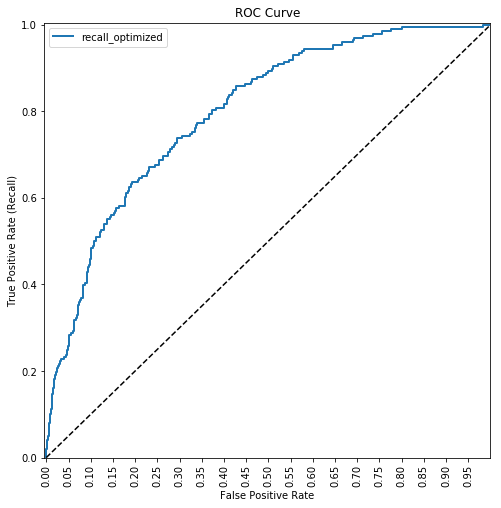

In [37]:
fpr, tpr, auc_thresholds = roc_curve(y_real, y_scores)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

In [38]:
y = val_labels[:,1][val_labels[:,1]>0]
yhat = val_outputs[:,1][val_labels[:,1]>0]

In [39]:
RMSE = np.sqrt(np.mean((y - yhat)**2))
RMSE

1032.9951

In [40]:
y = np.abs(val_labels[:,1])
p = val_outputs[:,0]
f2 = val_outputs[:,1]
yhat = (1-p)*f2

In [41]:
RMSE = np.sqrt(np.mean((y - yhat)**2))
RMSE

928.63586

In [42]:
print(np.cov(y, p))

[[ 9.70960988e+05 -3.21676627e+01]
 [-3.21676627e+01  3.05584785e-02]]


In [43]:
print(np.cov(f2, p))

[[ 8.73141042e+04 -2.80855152e+01]
 [-2.80855152e+01  3.05584785e-02]]
